In [45]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

from GMM_GMR import GMM_GMR

In [58]:
class DMP(object):
    def __init__(self, K=500, alpha=10, BF_number=20):
        # Spring constant and damping factor
        self.K = K             
        self.D = 2*np.sqrt(K)
        self.alpha = alpha
        
        # Basis functions
        self.BF_number = BF_number
        self.c = np.logspace(-3,0, num=self.BF_number) 
        self.h = BF_number / (self.c**2) 
        
        # Optimal weights
        self.w_hat = None     
        self.dt = None   
        
        # Perturbation step
        self.p_step = None

    def get_phases(self, time_steps, duration):
       # Return s vector with shape (n_steps, 1)
       return np.exp(-self.alpha * time_steps / duration)
    
    def get_phi(self, s):
        # Return phi(s) vector with shape (n_steps, 1)
        return np.exp(-self.h * (s - self.c) ** 2)

    def learn(self, z, duration):
        # Calculate x(t), v(t), vd(t)
        self.dt = duration / z.shape[0]
        time_steps = np.reshape(np.linspace(0, duration, num=z.shape[0]), (z.shape[0], 1))

        x0, g = z[0], z[-1]
        x = z.flatten()
        v = (np.diff(x, prepend=0)/self.dt) * duration
        vd = (np.diff(v, prepend=0)/self.dt) * duration

        # Integrate the canonical system
        s = self.get_phases(time_steps, duration)

        # Compute f_target(s)
        fts = (- self.K*(g - x) + self.D*v + duration*vd) / (g - x0)

        # Solve for optimal weights
        X = self.get_phi(s)
        y = np.multiply(fts, (np.sum(X, axis=1, keepdims=True) / s).ravel())
        self.w_hat = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

    def imitate_movement(self, x0, g, tau, perturbation=None):
        if perturbation:
            self.p_step = int(perturbation[0] / self.dt)

        n_steps = int(tau / self.dt)
        time_steps = np.reshape(np.linspace(0, duration, num=n_steps), (n_steps, 1))

        # Compute s and phi vectors
        s = self.get_phases(time_steps, tau)
        phi = self.get_phi(s)
        # Compute f(s) vector
        fs = np.sum((s * (self.w_hat.T * phi)), axis=1, keepdims=True) / np.sum(phi, axis=1, keepdims=True)
        
        # Initialize variables
        x, x_dot = x0, 0
        trajectory = 0
        for i in range(n_steps):
            if self.p_step and (self.p_step-1)==i:
                x = x + perturbation[0]
            v = tau * x_dot
            v_dot = (self.K*(g - x) - self.D*v - self.K*(g - x0)*s[i] + self.K*fs[i]) / tau
            v = v + v_dot * dt
            x_dot = v / tau
            x = x + x_dot * dt
            trajectory = np.row_stack((trajectory, x))
        return trajectory

    def plot_trajectory(self, x0, g, dmp_z):
        plt.plot(0, x0, 'ro')
        plt.plot(dmp_z.shape[0]-1, g, 'ro')
        plt.plot(dmp_z[1:], color='g', label='DMP Trajectory')

        if self.p_step:
            plt.axvline(self.p_step, linestyle='-.')
        plt.xlabel('Time steps')
        plt.ylabel('x')
        plt.legend()
        plt.show()

In [59]:
# Fit a GMM with 10 observations 
n_samples = 100
dt = 0.02
duration = n_samples * dt
time_steps = np.linspace(0, duration, num=n_samples)

# Read in observations
obs_files = [file for file in os.listdir('data') if file.endswith('.txt')]
obs = []
for file in obs_files:
    path = 'data/' + file
    obs.append(np.row_stack((time_steps, np.asarray([float(line.rstrip()) for line in open(path)]))))

obs = np.concatenate(obs, axis=1)

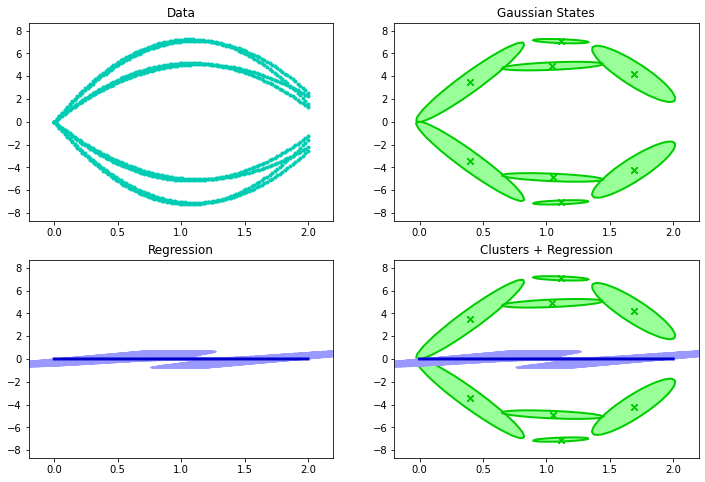

In [60]:
#Fit Gaussian Mixture Model with 8 components
gmr = GMM_GMR(8)
gmr.fit(obs)

# Gaussian Mixture Regression
gmr.predict(time_steps)

# Plot results
fig = plt.figure()
ax1 = fig.add_subplot(221)
plt.title("Data")
gmr.plot(ax=ax1, plotType="Data")

ax2 = fig.add_subplot(222)
plt.title("Gaussian States")
gmr.plot(ax=ax2, plotType="Clusters")

ax3 = fig.add_subplot(223)
plt.title("Regression")
gmr.plot(ax=ax3, plotType="Regression")

ax4 = fig.add_subplot(224)
plt.title("Clusters + Regression")
gmr.plot(ax=ax4, plotType="Clusters")
gmr.plot(ax=ax4, plotType="Regression")
plt.show()

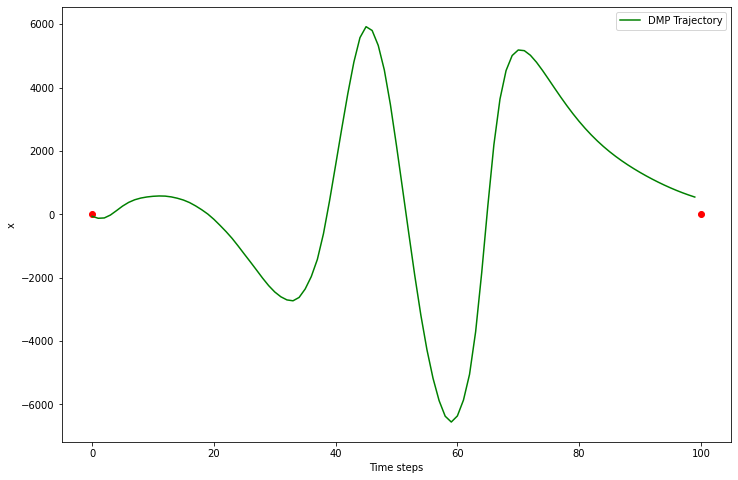

In [61]:
# GMR for GMM with 8 components
z = gmr.reg_line.flatten()[:, np.newaxis]

# Reproduce the trajectory 20 basis functions
dmp = DMP(K=500, alpha=10, BF_number=20)
dmp.learn(z, duration)
trajectory = dmp.imitate_movement(z[0], z[-1], duration)
dmp.plot_trajectory(z[0], z[-1], trajectory)

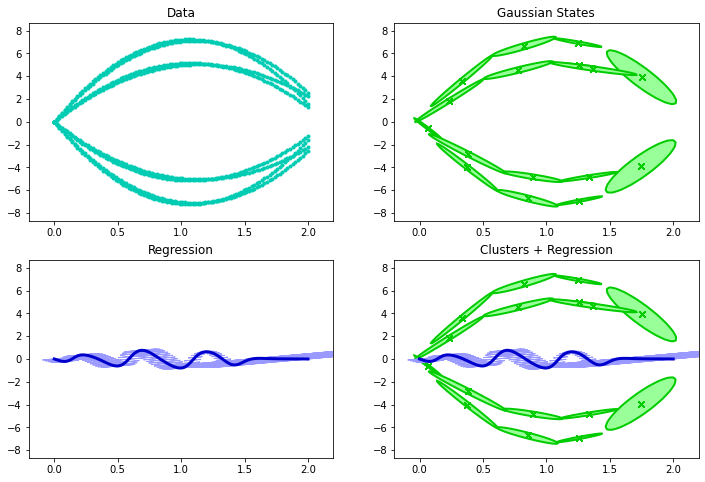

In [62]:
#Fit Gaussian Mixture Model with 16 components
gmr = GMM_GMR(16)
gmr.fit(obs)

# Gaussian Mixture Regression
gmr.predict(time_steps)

# Plot results
fig = plt.figure()
ax1 = fig.add_subplot(221)
plt.title("Data")
gmr.plot(ax=ax1, plotType="Data")

ax2 = fig.add_subplot(222)
plt.title("Gaussian States")
gmr.plot(ax=ax2, plotType="Clusters")

ax3 = fig.add_subplot(223)
plt.title("Regression")
gmr.plot(ax=ax3, plotType="Regression")

ax4 = fig.add_subplot(224)
plt.title("Clusters + Regression")
gmr.plot(ax=ax4, plotType="Clusters")
gmr.plot(ax=ax4, plotType="Regression")
plt.show()

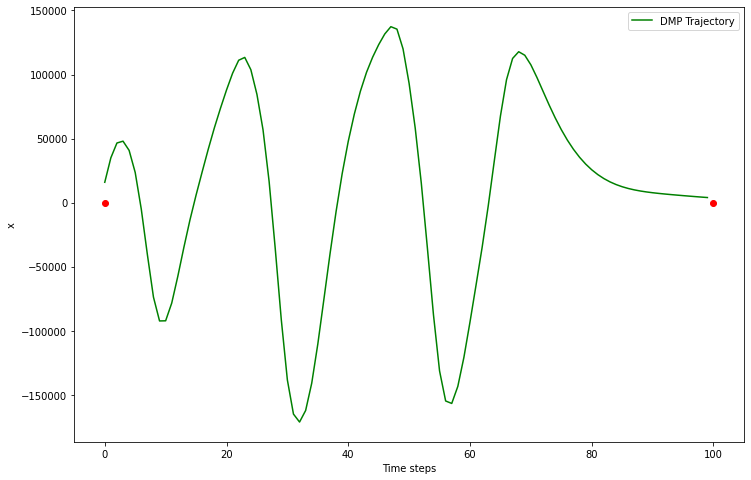

In [63]:
# GMR for GMM with 16 components
z = gmr.reg_line.flatten()[:, np.newaxis]

# Reproduce the trajectory 20 basis functions
dmp = DMP(K=500, alpha=10, BF_number=20)
dmp.learn(z, duration)
trajectory = dmp.imitate_movement(z[0], z[-1], duration)
dmp.plot_trajectory(z[0], z[-1], trajectory)